In [1]:
from math import e, factorial,log, gamma, sqrt, floor
from matplotlib import pyplot as plt
from numpy.random import geometric,exponential,poisson
from scipy.stats import ks_2samp
from scipy.stats import norm
from numpy import linspace
from IPython.display import Markdown
from threading import Thread
from timestamp import *
import re
import numpy as np

In [2]:
plt.rcParams["figure.figsize"] = (20,10)

def computeEvents(V, ttx, trx, tn):
    Eb = 0
    Es = 0
    En = 0

    for c in V:
        if c == 'B':  # broadcast event is a B sorrounded by 14 X
            Eb += 1
        elif c == 'S':
            Es += 1
        elif c == 'N':
            En += 1

    return (Eb, Es/trx, En/tn)


def geom_dist(p, maxK, k0=0):
    return [p*(1-p)**(k-k0) for k in range(0, maxK)]


def poisson_dist(lam, maxK):
    return [e**(k*log(lam)-(lam)-log(gamma((k+1)))) for k in range(0, maxK)]


def exponential_dist(lam, maxK):
    return [lam*(e**(-lam*k)) for k in range(0, maxK)]


def gamma_dist(beta, maxK, alpha):
    k = (beta**alpha)/gamma(alpha)
    return [k*(x**(alpha-1))*exp(-beta*x) for x in range(maxK)]


def rmse(v1, v2):
    rmse = 0
    for x1, x2 in zip(v1, v2):
        rmse += (x1-x2)**2
    return sqrt(rmse/len(v1))


def checkSuccess(Vtx, Vrx):
    Cb = 0

    for b, s in zip(Vtx, Vrx):
        if b == 'B' and s == 'S':
            Cb += 1
    return Cb  # number of successfull events


def findScanInterval(Vtx, Vrx, Ttx, Trx):
    scan_intervals = [{'s': m.start(), 'e': m.end(), 'n': 0}
                      for m in re.finditer(Trx*'S', Vrx)]
    for si in scan_intervals:
        si['n'] = Vtx[si['s']:si['e']].count(Ttx*'B')

    return scan_intervals


def generateHistogram(sc_int, Trx):
    hist = [0 for x in range(Trx+1)]
    for si in sc_int:
        hist[si['n']] += 1
    for i in range(Trx+1):
        hist[i] /= len(sc_int)
    return hist


def genWindowHistogram(r1, r2, wnd):
    windows = []
    for i in range(0, len(r1), wnd):
        count = 0
        for j in range(i, i+wnd):
            try:
                if r1[j] == 'S' and r2[j] == 'B':
                    count += 1
            except:
                pass
        windows.append(count)

    result = [0 for i in range(wnd)]
    for n in range(len(result)):
        result[n] = windows.count(n)/len(windows)
    print(sum(result))
    return result

def expand(raw, Ttx, Trx, Tn):
    buffer = []
    rs = raw.split(',')
    for c in rs:
        if c == '':
            continue
        elif 'S' in c:
            buffer.extend(Trx*'S')
        elif 'N' in c:
            buffer.extend(Tn*'N')
        else:
            n = int(c.replace('B',''))
            for i in range(Ttx):
                if i == n:
                    buffer.append('B')
                else:
                    buffer.append('X')
    return buffer
    
def compute_histogram(r1, r2, Trx, Ttx, Tn):

    Eb1, Es1, En1 = computeEvents(r1, Ttx, Trx, Tn)
    Eb2, Es2, En2 = computeEvents(r2, Ttx, Trx, Tn)
    display(Markdown('<span style="color: #af0000">' +
                     "P(S) = %.6f" % (Trx*Es1/len(r1))+'</span>'))
    display(Markdown('<span style="color: #00af00">' +
                     "P(N) = %.6f" % (Tn*En1/len(r1))+'</span>'))
    display(Markdown('<span style="color: #0000af">' +
                     "P(B) = %.6f" % (Ttx*Eb1/len(r1))+'</span>'))

    Pb2 = Eb2*Ttx/(Eb2*Ttx+En2*Tn+Es2*Trx)
    rt1 = Pb2/(Ttx/1000)

    print("r(B)(Events/s) = %.6f" % (rt1))

    hist1 = genWindowHistogram(r1, r2, 1000)
    Esuc = checkSuccess(r2, r1)
    Ps = Esuc/Eb2
    rs2 = Esuc*1000/len(r1)
    print("r(Suuccess)(Events/s) = %.6f" % rs2)
    Pscan = Trx*Es1/len(r1)
    r_scan = 1000*Pscan/Trx
    print("r(S)(Events/s) = %.6f" % r_scan)
    Ns = Ps*1000/Ttx
    Nb = rt1*1000
    print("Success probability evts: %.6f" % (Ps))
    return hist1, Eb1, Es1, En1, Ps

In [3]:
Ttx = 30
Trx = 60
Tn = 100
    
def compute_histogram(r1,r2):

    Eb1,Es1,En1 = computeEvents(r1,Ttx,Trx,Tn)
    Eb2,Es2,En2 = computeEvents(r2,Ttx,Trx,Tn)
    display(Markdown('<span style="color: #af0000">'+"P(S) = %.6f"%(Trx*Es1/len(r1))+'</span>'))
    display(Markdown('<span style="color: #00af00">'+"P(N) = %.6f"%(Tn*En1/len(r1))+'</span>'))
    display(Markdown('<span style="color: #0000af">'+"P(B) = %.6f"%(Ttx*Eb1/len(r1))+'</span>'))

    Pb2 = Eb2*Ttx/(Eb2*Ttx+En2*Tn+Es2*Trx)
    rt1 = Pb2/(Ttx/1000)
    
    print("r(B)(Events/s) = %.6f"%(rt1))
    
    hist1 = genWindowHistogram(r1,r2,1000)
    Esuc = checkSuccess(r2,r1)
    Ps=Esuc/Eb2
    rs2 = Esuc*1000/len(r1)
    print("r(Suuccess)(Events/s) = %.6f"%rs2)
    Pscan = Trx*Es1/len(r1)
    r_scan = 1000*Pscan/Trx
    print("r(S)(Events/s) = %.6f"%r_scan)
    Ns = Ps*1000/Ttx
    Nb = rt1*1000
    print("Success probability evts: %.6f"%(Ps))
    return hist1,Eb1,Es1,En1,Ps
MSG = re.compile(r'D[0-9]+-.*\*')
SENT = re.compile(r'[0-9]+:[0-9]+:[0-9]+\.[0-9]+')

def save(filename,data):
    with open(filename,'w') as fn:
        for d in data:
            print(d,file=fn)
            
def read_file(filename):
    with open(filename) as f:
        raw = f.readlines()
        return raw
    
def cleanup(line):
    return line.replace('(','').replace("'","").replace(')','').replace('b','').replace('\\t',',').replace('\\r\\n','').replace('"','').strip()
    
def read_data(raw):
    
    rec = []
    
    for line in raw:
        clean = cleanup(line)
        
        ssid = MSG.findall(clean)
        
        if len(ssid) > 0:
                                
            #try:
            ls = clean.split(',')
            ts = TimeStamp(ls[0])
            ssid_str = ssid[0][1:18]
            #rssi = int(ls[2][5:])
            rec.append((ts,ssid_str))
           # except:
            #    print(clean)
                
                
    return rec
                
                
    return rec
def get_sent(lines):
    
    sent = []
    for line in lines:
        if 'B-' in line:
            clean = cleanup(line)
            ls = clean.split(',')
            s = ls[2].replace('*','').replace('sent:','').strip()
            sent.append((ls[0],s))
    return sent
def get_net(lines):
    
    net = []
    for line in lines:
        if 'N-' in line:
            clean = cleanup(line)
            ls = clean.split(',')
            #s = ls[2].replace('*','').replace('sent:','').strip()
            net.append(ls)
    return net

def sent_frequency(sent):
    t0 = TimeStamp(sent[0][0]).toSeconds()
    
    t1 = TimeStamp(sent[-1][0]).toSeconds()
    if(t1 < t0):
        t1 = t0+ 10800
    
    print('-----------Debug------------')
    print('t0=',t0)
    print('t1=',t1)
    print(len(sent))
    print('----------------------------')
    return len(sent)/(t1-t0)

def compute_ttx(raw):

    diff = []
  
    for line in raw:
        
        if 'B-dur' in line:
            clean = cleanup(line)
            ls = clean.split(',')
            s = ls[1].split(':')[1]
            d = float(s)
            diff.append(d)
            
    return diff

def compute_trx(raw):

    diff = []
  
    for line in raw:
        
        if 'S-dur' in line:
            clean = cleanup(line)
            ls = clean.split(',')
            s = ls[1].split(':')[1]
            d = float(s)
            diff.append(d)
            
    return diff

def compute_tn(raw):

    diff = []
  
    for line in raw:
        
        if 'N-dur' in line:
            clean = cleanup(line)
            ls = clean.split(',')
            s = ls[1].split(':')[1]
            d = float(s)
            diff.append(d)
            
    return diff

def scan_frequency(raw):
   
    scans = []
  
    for line in raw:
        if 'S' in line:
            clean = cleanup(line)
            ls = clean.split(',')
            scans.append(ls[0])
    t0 = TimeStamp(scans[0]).toSeconds()
    t1 = TimeStamp(scans[-1]).toSeconds()
    if(t1 < t0):
        t1 = t0+ 10800
    print('-----------Debug scan------------')
    print('t0=',t0)
    print('t1=',t1)
    print(len(scans))
    print('----------------------------')
    return len(scans)/(t1-t0)

def net_frequency(net):
    t0 = TimeStamp(net[0][0]).toSeconds()
    t1 = TimeStamp(net[-1][0]).toSeconds()
    if(t1 < t0):
        t1 = t0+ 10800
    print('-----------Debug net------------')
    print('t0=',t0)
    print('t1=',t1)
    print(len(net))
    print('----------------------------')
    return len(net)/(t1-t0)


def analysis(res1,res2,n1,n2):
    rec = read_data(res2)
    
    tr = Thread(target=save,args=('received-%s.txt'%n2,rec))
    tr.start()
    sent = get_sent(res1)
    net = get_net(res1)
    print(len(sent))
    #tr2 = Thread(target=save,args=('sent-%s.txt'%n1,sent))
    #tr2.start()
      
    #sent_set = set([s[1] for s in sent])
    rec_set = set([r[1].replace('*','') for r in rec])
    #received = len(rec_set.intersection(sent_set))
    t0 = rec[0][0].toSeconds()
    t1 = rec[-1][0].toSeconds()
    
    print('Reception rate: ',len(rec)/(t1-t0))
    
    print('Success: %.6f%%'%(100*len(rec)/len(sent)))

    print('Transmission rate [msg/s]:', sent_frequency(sent))
    print('Networking rate [packet/s]:',net_frequency(net))
            
    wnd = {}
    wnd[0] = []
    tref = rec[0][0].toSeconds()
    i = 0
    for r in rec:
        if r[0].toSeconds() - tref < 1:
            wnd[i].append(r)
        else:
            tref = r[0].toSeconds()
            i += 1
            wnd[i] = []
    hist = []
    for w in wnd:
        hist.append(len(wnd[w]))
    tr.join()
    #tr2.join()
    return hist, 100*len(rec)/len(sent)

def duty_cycle(res,dtx,drx,dn):
    B = 0
    S = 0
    N = 0
    for line in res:
        if 'B' in line:
            B+=1
        if 'S' in line:
            S+=1
        if 'N' in line:
            N+=1
            
    Btime = B*np.average(dtx)/1000
    Stime = S*np.average(drx)/1000
    Ntime = N*np.average(dn)/1000
    print('B(%): ',100*Btime/(Btime+Stime+Ntime))
    print('S(%): ',100*Stime/(Btime+Stime+Ntime))
    print('N(%): ',100*Ntime/(Btime+Stime+Ntime))
    
def pois(l,k):
    v = []
    for x in range(k):
        p = (l**x)*exp(-l)/factorial(x)
        v.append(p)
    return v

158247
Reception rate:  3.9109784110821995
Success: 26.689290%
-----------Debug------------
t0= 53839.416364
t1= 64639.341252
158247
----------------------------
Transmission rate [msg/s]: 14.65260190613281
-----------Debug net------------
t0= 53839.733117
t1= 64636.528308
10417
----------------------------
Networking rate [packet/s]: 0.9648233402337216
----------------------------------------
Average success rate:  26.689289528395484 %
----------------------------------------
-----------Debug scan------------
t0= 53839.573983
t1= 64639.441954
78563
----------------------------
scan freq(res-0):  7.2744407812168435
Average Ttx (res-0):  31.12254736492909
Average Trx (res-0):  61.61371400022911
Average Tn (res-0):  101.14573814919736
B(%):  45.212308940625405
S(%):  44.86076520398622
N(%):  9.926925855388363
----------------------------------------
-----------Debug scan------------
t0= 53839.388454
t1= 64639.401093
78430
----------------------------
scan freq(res-1):  7.262028538446416


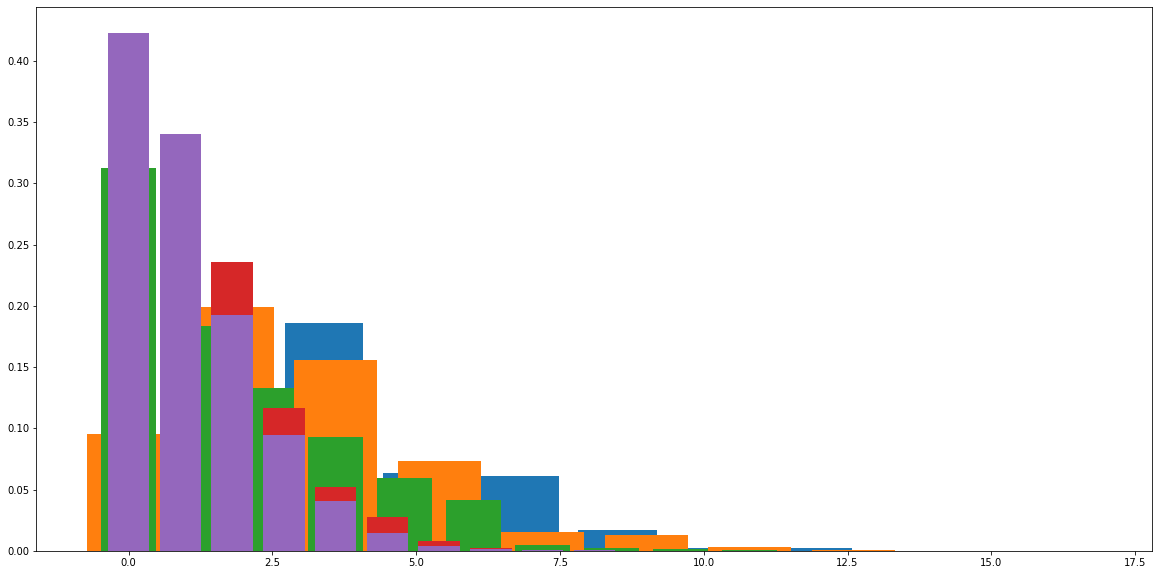

In [4]:
res = []
xy = []

for j in [10,20,30,40,50]:
    res.append(read_file('res-2_%d.txt'%j))
    res.append(read_file('res-1_%d.txt'%j))
               


    h_xy = []
    s_xy = []
    
    h,s = analysis(res[-1],res[-2],'res-1_%d'%j,'res-2_%d'%j)
    h_xy.append(h)
    s_xy.append(s)

    print('----------------------------------------')
    print('Average success rate: ',np.average(s_xy),'%')
    print('----------------------------------------')

    diff_tx = []
    diff_rx = []
    diff_n = []
    for i in range(2):
        diff_tx.append(compute_ttx(res[i]))
        diff_rx.append(compute_trx(res[i]))
        diff_n.append(compute_tn(res[i]))
        print('scan freq(res-%d): '%i,scan_frequency(res[i]))


        print('Average Ttx (res-%i): '%i,np.average(diff_tx[i])/1000)
        print('Average Trx (res-%i): '%i,np.average(diff_rx[i])/1000)
        print('Average Tn (res-%i): '%i,np.average(diff_n[i])/1000)
        duty_cycle(res[i],diff_tx[i],diff_rx[i],diff_n[i])

        print('----------------------------------------')
    xy.append(plt.hist(h_xy[0],density=True,histtype='bar',align='left',rwidth=0.8))

plt.show()





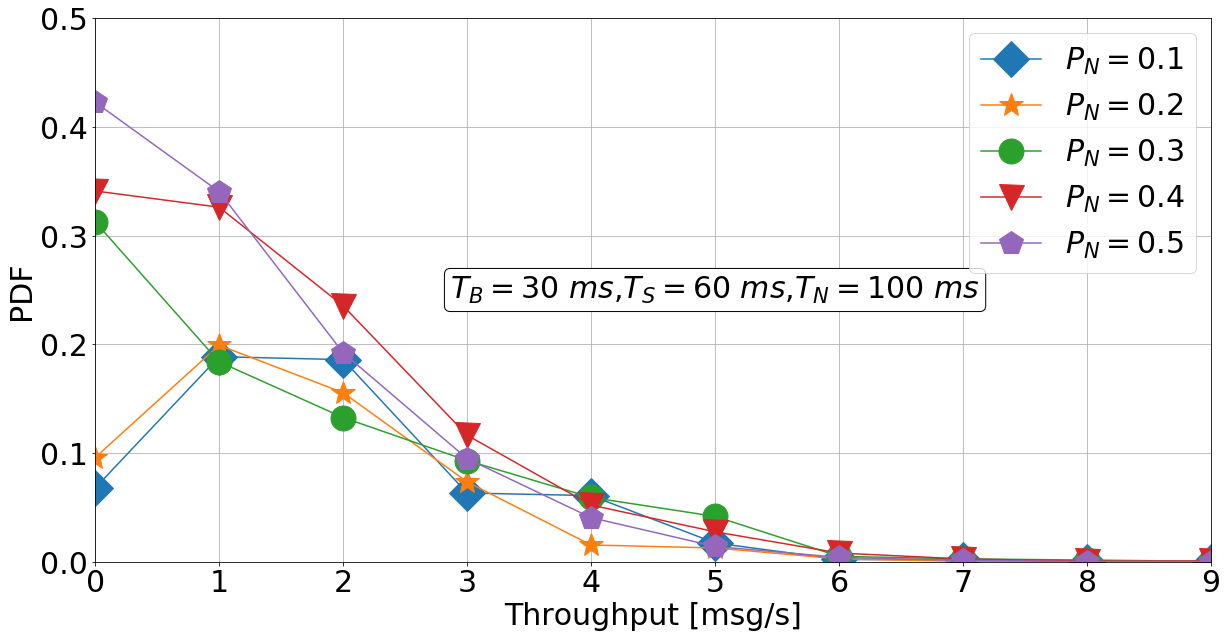

In [5]:
markers = ['D','*','o','v','p']
lb = ["0.1","0.2","0.3","0.4","0.5"]
for p,m,l in zip(xy,markers,lb):
    plt.plot(p[0],'-'+m,markersize=25, label = '$P_N=$'+l)


plt.text(5,0.25,"$T_B=30~ms$,$T_S=60~ms$,$T_N=100~ms$",{'color': 'black', 'fontsize': 30, 'ha': 'center', 'va': 'center',
          'bbox': dict(boxstyle="round", fc="white", ec="black", pad=0.2)})
plt.axis([0,9,0,0.5])
plt.xlabel('Throughput [msg/s]',fontsize=30)
plt.ylabel('PDF',fontsize=30)
plt.xticks(range(0,10),fontsize=30)
plt.yticks(fontsize=30)
plt.grid(True)
plt.legend(fontsize=30)
plt.savefig('rx_dist_net.pdf',dpi=300,bbox_inches='tight')
plt.show()